In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Tue Nov 30 10:38:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install -q -U watermark
!pip install -qq transformers
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 2.1.2 which is incompatible.
     |████████████████████████████████| 3.1 MB 12.8 MB/s 
     |████████████████████████████████| 3.3 MB 46.6 MB/s 
     |████████████████████████████████| 59 kB 8.0 MB/s 
     |████████████████████████████████| 895 kB 60.7 MB/s 
     |████████████████████████████████| 596 kB 46.3 MB/s 
Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.10.0+cu111
transformers: 4.12.5



In [4]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, AutoTokenizer, AutoModelForSequenceClassification
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import f1_score

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# New Section

In [5]:
from transformers import BertTokenizer,BertModel
# PRE_TRAINED_MODEL_NAME = "hfl/chinese-roberta-wwm-ext"
# PRE_TRAINED_MODEL_NAME = "hfl/chinese-roberta-wwm-ext-large"
# PRE_TRAINED_MODEL_NAME = "hfl/chinese-bert-wwm-ext"
PRE_TRAINED_MODEL_NAME = "bert-base-uncased"
# PRE_TRAINED_MODEL_NAME = "ProsusAI/finbert"
# PRE_TRAINED_MODEL_NAME = "bert-base-chinese"
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME,do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [6]:
data1 = pd.read_csv('/content/drive/MyDrive/project/data/Twitter_Data.csv')

In [7]:
data1 = data1.rename(columns={'clean_text':'text','category':"rating"})

In [8]:
data1 = data1.loc[~data1.rating.isna()]

In [9]:
df_train = pd.read_csv('/content/drive/MyDrive/project/data/train.csv',sep='\t')
df_test = pd.read_csv('/content/drive/MyDrive/project/data/test.csv',sep='\t')

In [10]:


# config = BertConfig.from_json_file('/content/drive/MyDrive/model/chinese_wwm_pytorch/bert_config.json')


In [11]:
# data = pd.read_csv('/content/drive/MyDrive/project/data/generatedBy_react-csv (45).csv')
# data = data.sample(frac=1)
# data = data.reset_index(drop=True)


# df_train = data.loc[:int(len(data)*0.6)]
# df_train.to_csv('/content/drive/MyDrive/project/data/train.csv',sep='\t',index=None)
# df_test = data.loc[int(len(data)*0.6):]
# df_test.to_csv('/content/drive/MyDrive/project/data/test.csv',sep='\t',index=None)

In [12]:
df_train = df_train[['text','rating']]
df_test = df_test[['text','rating']]

In [13]:
data1 = pd.concat([df_train,data1])
data1 = data1.reset_index(drop=True)
data1.rating = data1.rating.astype('int')
data1 = data1.sample(frac=0.1)
data1 = data1.reset_index(drop=True)

In [14]:
len(data1)*0.9

14684.4

In [15]:
df_train = data1.loc[:int(len(data1)*0.9)]

In [16]:
df_val = data1.loc[int(len(data1)*0.9):]

In [17]:
df_train

,text,rating
0,chutiya keep nation waiting for his address pe...,1
1,what the result takes narendra modi from varan...,0
2,years not enough wipe out the misdeeds 60yrs t...,0
3,Deadlines to make a submission to the National...,0
4,trust believe support modi bjp,0
...,...,...
14680,your daily dose laughter,0
14681,some ppl are saying that want vote congress an...,0
14682,there very little time left and weakening bjp ...,-1
14683,the contesting kerala direct assault the liner...,1


In [18]:
# data.text = data.text.str.replace('[newLine]','')
# data.text = data.text.str.replace('[doubleQuote]','\"')

In [19]:
df_train.rating = df_train.rating+1
df_test.rating = df_test.rating+1
df_val.rating = df_val.rating+1

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [20]:
df_train,df_test,df_val

(                                                    text  rating
 0      chutiya keep nation waiting for his address pe...       2
 1      what the result takes narendra modi from varan...       1
 2      years not enough wipe out the misdeeds 60yrs t...       1
 3      Deadlines to make a submission to the National...       1
 4                         trust believe support modi bjp       1
 ...                                                  ...     ...
 14680                          your daily dose laughter        1
 14681  some ppl are saying that want vote congress an...       1
 14682  there very little time left and weakening bjp ...       0
 14683  the contesting kerala direct assault the liner...       2
 14684         couldnt the modi have announced this joker       2
 
 [14685 rows x 2 columns],
                                                   text  rating
 0    @✱✱✱ promised big news re. biomarker testing &...       2
 1    How can we maximise the potential of precisio

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


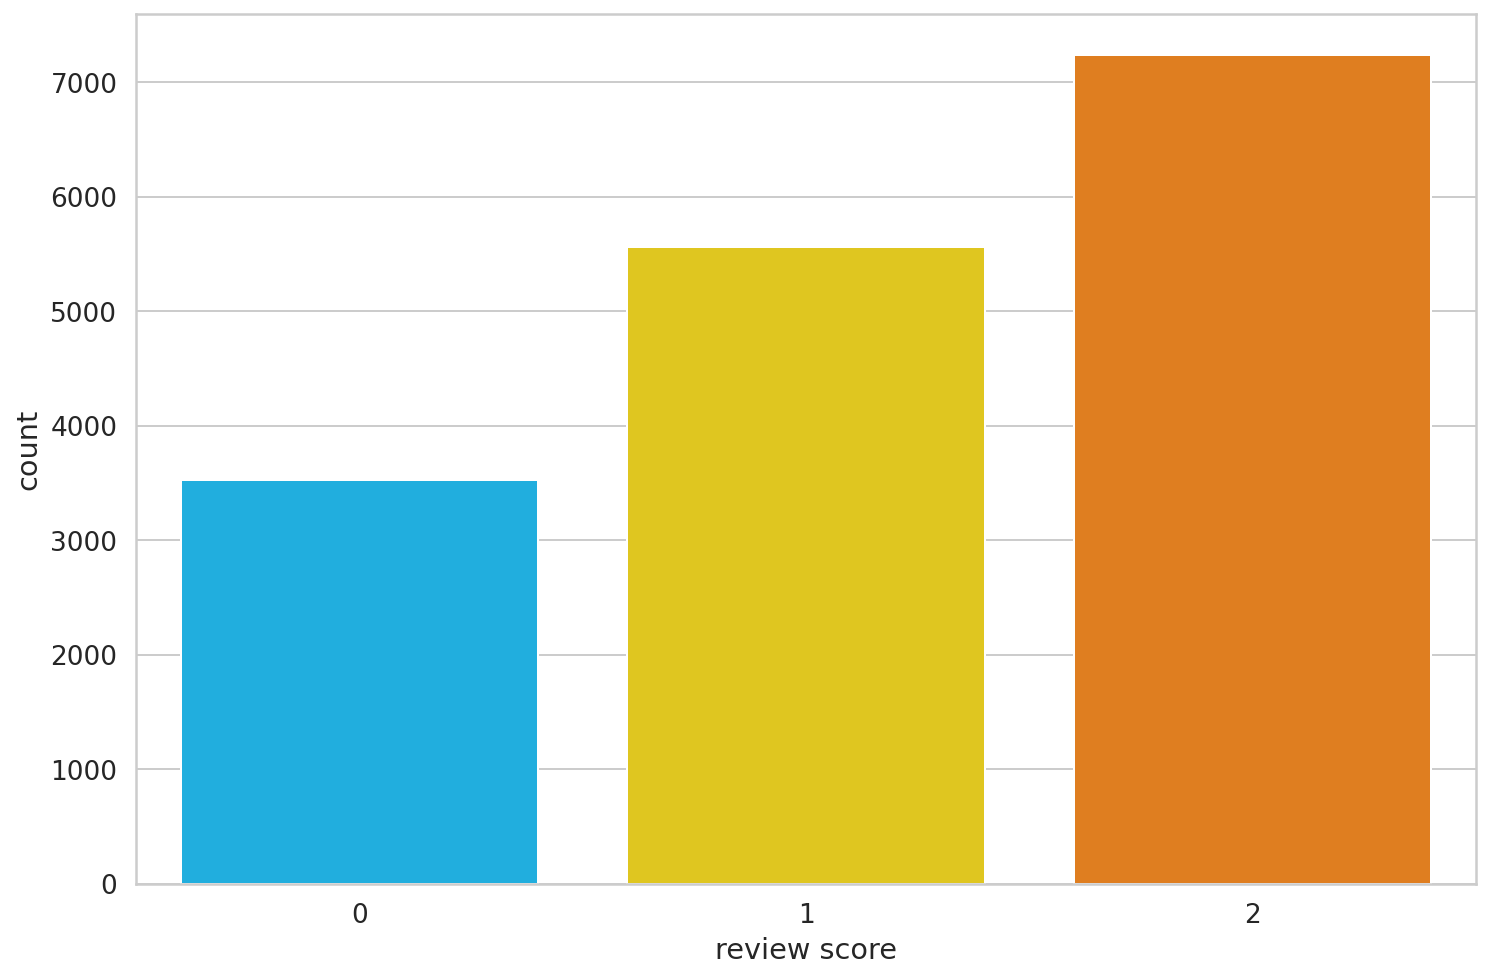

In [21]:
sns.countplot(data1.rating)
plt.xlabel('review score');

In [22]:
# df_train = data.loc[0:0.6*len(data)]
# df_val = data.loc[0.6*len(data):0.8*len(data)]
# df_test = data.loc[0.8*len(data):]

In [23]:
# tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME,do_lower_case=True, tokenize_chinese_chars=True)

In [24]:
# train = pd.read_csv('/content/drive/MyDrive/data/chnsenticorp/train.tsv',sep='\t')
# test = pd.read_csv('/content/drive/MyDrive/data/chnsenticorp/test.tsv',sep='\t')
# dev = pd.read_csv('/content/drive/MyDrive/data/chnsenticorp/dev.tsv',sep='\t')

In [25]:
# train = train.rename(columns = {'label':"LABEL",'text_a':'news'})
# test = test.rename(columns = {'label':"LABEL",'text_a':'news'})
# dev = dev.rename(columns = {'label':"LABEL",'text_a':'news'})

In [26]:
# df = train

In [27]:
# df.loc[df.DESCRIPTION.apply(len)>300].head(5)

In [28]:
# sample_txt = df.loc[12085,"DESCRIPTION"]

In [29]:
# len(sample_txt)

In [30]:
# sample_txt.loc[3406]['DESCRIPTION_EN']

In [31]:
sample_txt = 'Rambler expects net profit in the first quarter to increase by 70% - 80% year on year'

In [32]:
# sample_txt = sample_txt
# tokens = tokenizer.tokenize(sample_txt)
# token_ids = tokenizer.convert_tokens_to_ids(tokens)

# print(f' Sentence: {sample_txt}')
# print(f'   Tokens: {tokens}')
# print(f'Token IDs: {token_ids}')

In [33]:
# sentences = df["DESCRIPTION"].values

In [34]:
# sentence = sample_txt.split(' ')

In [35]:
# sentence.insert(1,'')
# sentence.insert(13,'')
# sentence.insert(16,'')

In [36]:
# s = pd.DataFrame([sentence,tokens,token_ids])
# # s = s.rename(columns={0:"Tokens",1: "Token IDs"})
# s[20] = pd.Series(["Sentence:","Token:",'Token IDs:'])

In [37]:
# s = s.set_index([20])


In [38]:
# s.style.set_properties(**{'text-align': 'left'})
# s

In [39]:
# max_len = 0

# # For every sentence...
# for sent in sentences:

#     # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
#     input_ids = tokenizer.encode(sent, add_special_tokens=True)

#     # Update the maximum sentence length.
#     max_len = max(max_len, len(input_ids))

# print('Max sentence length: ', max_len)

In [40]:
max_len=300

In [41]:
# a = np.array([*map(len,sentences)])
# np.where(a > 300)

In [42]:
# encoding = tokenizer.encode_plus(
#   sample_txt,
#   max_length=max_len,
#   add_special_tokens=True, # Add '[CLS]' and '[SEP]'
#   return_token_type_ids=False,
#   pad_to_max_length=True,
#   padding='max_length',
#   truncation=True,
#   return_attention_mask=True,
#   return_tensors='pt',  # Return PyTorch tensors
# )

# # encoding.keys()

In [43]:
# print(len(encoding['input_ids'][0]))
# encoding['input_ids'][0]

In [44]:
# print(len(encoding['attention_mask'][0]))
# encoding['attention_mask']

In [45]:
# tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

In [46]:
# token_lens = []

# for txt in df.DESCRIPTION:
#   tokens = tokenizer.encode(txt, max_length=300)
#   token_lens.append(len(tokens))

In [47]:
max_len = 300

In [48]:
class_names = ['negative','neutral', 'positive']

In [49]:
# sns.distplot(token_lens)
# plt.xlabel('Token count')

In [50]:
# MAX_LEN = 300
# from torch.utils.data import Dataset

In [51]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [52]:
# name = "CHANGE"
# path = '/content/drive/MyDrive/data/df_'
# df_train = pd.read_csv(path+"train_srl.csv",sep='\t',index_col=None)
# df_test = pd.read_csv(path+"test_srl.csv",sep='\t',index_col=None)
# df_val = pd.read_csv(path+"val_srl.csv",sep='\t',index_col=None)

In [53]:
# sns.countplot(pd.concat([df_train,df_test,df_val]).label)
# plt.xlabel('review score');

In [54]:
df_train.shape, df_val.shape, df_test.shape

((14685, 2), (1632, 2), (126, 2))

In [55]:
# # df_train, df_test,df_val = train, test,dev
# tem_train = df_train[["DATE","DESCRIPTION_EN_ZH","LABEL"]]
# tem_train1 = df_train[["DATE","DESCRIPTION","LABEL"]]
# # df_train = pd.concat([df_train[]

In [56]:
# 

In [57]:
# tem_train = tem_train.rename(columns={"DESCRIPTION_EN_ZH":"DESCRIPTION"})

In [58]:
# df_train = pd.concat([tem_train1,tem_train])

In [59]:
# df_train = df_train.sort_values("DATE")

In [60]:
# df_train.shape, df_val.shape, df_test.shape

In [61]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text.to_numpy(),
    targets=df.rating.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [62]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, max_len, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, max_len, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, max_len, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [63]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    # self.drop = nn.Dropout(p=0.1)
    # self.relu = nn.ReLU()
    # self.L1 = nn.Linear(self.bert.config.hidden_size,self.bert.config.hidden_size//2)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )[1]
    
    # output = self.drop(pooled_output)
    # # output = self.L1(output)
    output = self.out(pooled_output)
 
    return output

In [64]:
model = SentimentClassifier(3)
model = model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [65]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [66]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [67]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [68]:
history = defaultdict(list)
best_accuracy = 0
# EPOCHS = 5

In [69]:
%%time

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc
  torch.save(model.state_dict(), 'last_model_state.bin')

Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.49749878674546716 accuracy 0.8088525706503235
Val   loss 0.2738420577792853 accuracy 0.9123774509803921

Epoch 2/10
----------
Train loss 0.20643293001097557 accuracy 0.9415730337078652
Val   loss 0.23031385105979793 accuracy 0.9424019607843137

Epoch 3/10
----------
Train loss 0.12236147058325209 accuracy 0.9688117126319373
Val   loss 0.2630378027531026 accuracy 0.9411764705882353

Epoch 4/10
----------
Train loss 0.08077290243786721 accuracy 0.9814096016343208
Val   loss 0.3159104037599629 accuracy 0.9405637254901961

Epoch 5/10
----------
Train loss 0.05541953725326519 accuracy 0.9876744977868573
Val   loss 0.2991320519241865 accuracy 0.9411764705882353

Epoch 6/10
----------
Train loss 0.0400934441567146 accuracy 0.9906026557711951
Val   loss 0.3230488325243641 accuracy 0.9448529411764706

Epoch 7/10
----------
Train loss 0.026313362420833448 accuracy 0.9939393939393939
Val   loss 0.2960062633885137 accuracy 0.9491421568627451

Epoch 8/10
----------
Train loss 0.018835

In [70]:
len(history["train_acc"])

10

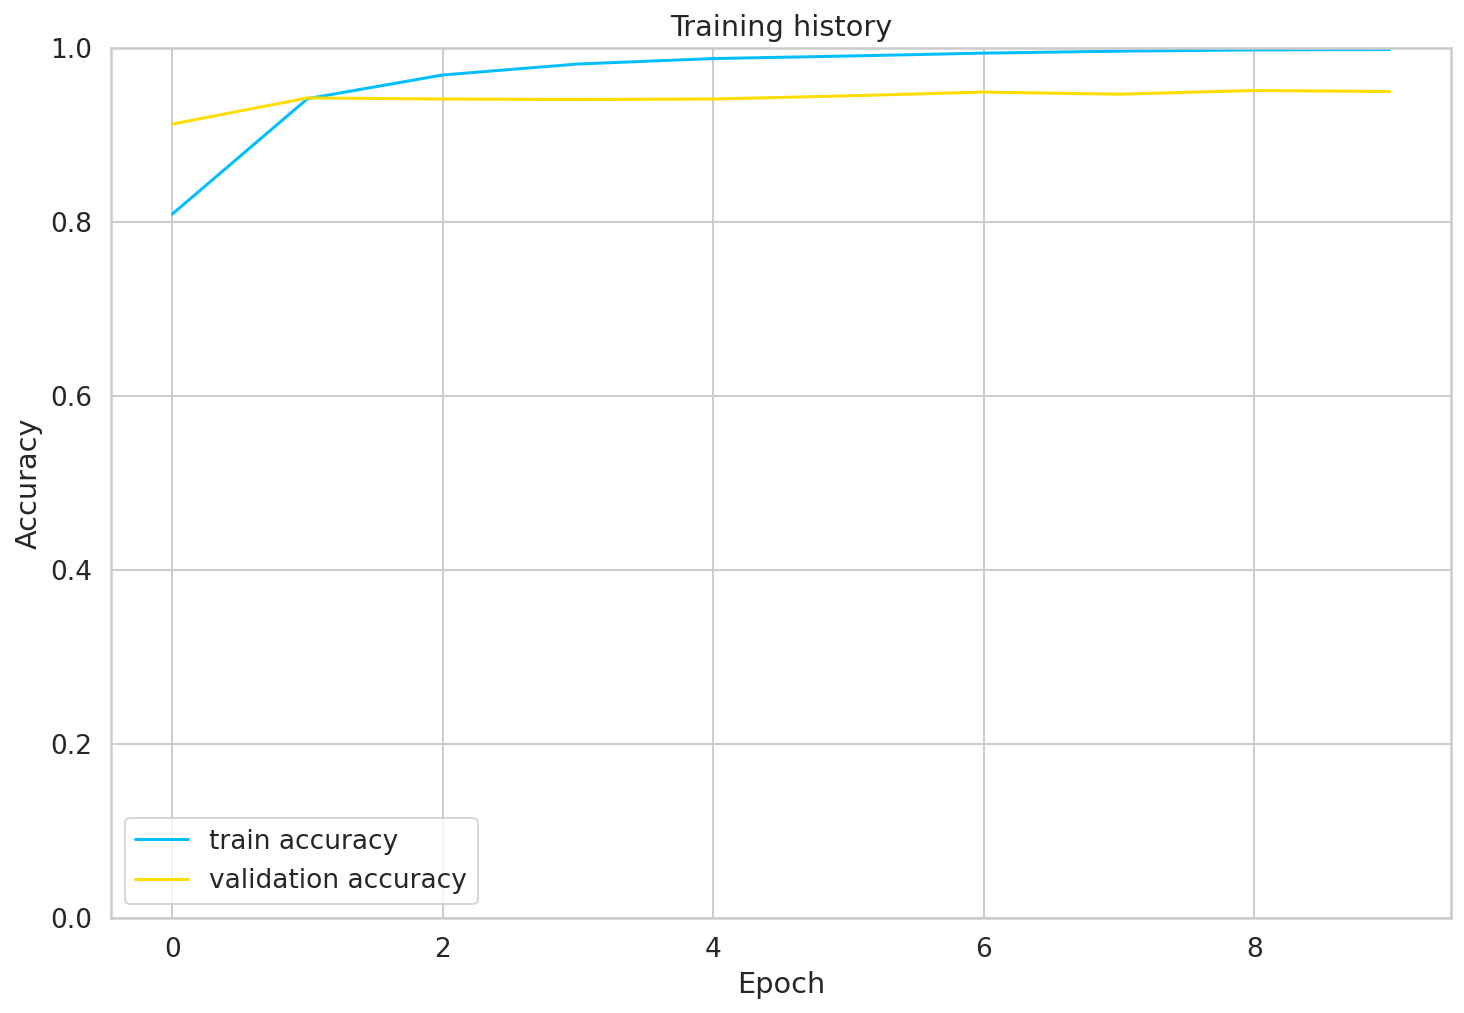

In [71]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [72]:
# tokenizer.save_vocabulary('vacab.txt')

In [73]:
# tokenizer.save_pretrained('content/drive/MyDrive/model/best_model/')

In [74]:
# model.bert.save_pretrained('best_model_state.bin')

In [75]:
# !gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA

model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [76]:
len(df_test)

126

In [77]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.5396825396825397

In [78]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [79]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [80]:
print(classification_report(y_test, y_pred, target_names=class_names,digits = 4))

              precision    recall  f1-score   support

    negative     0.2500    0.0526    0.0870        19
     neutral     0.4286    0.3947    0.4110        38
    positive     0.5977    0.7536    0.6667        69

    accuracy                         0.5397       126
   macro avg     0.4254    0.4003    0.3882       126
weighted avg     0.4943    0.5397    0.5021       126



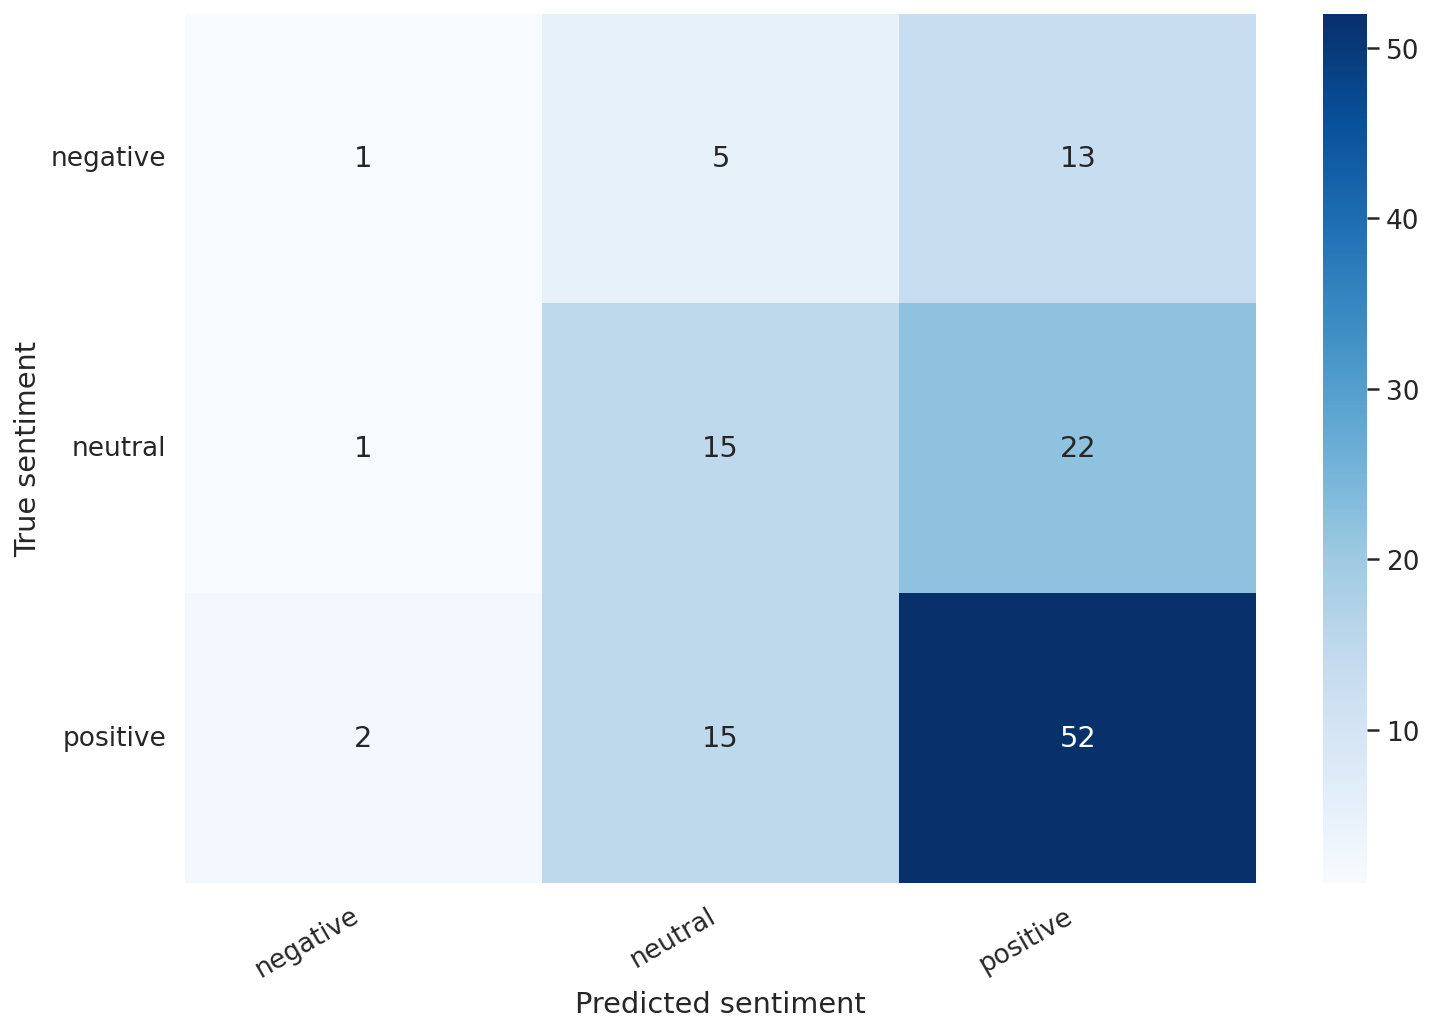

In [81]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [82]:
# !pip install lit-nlp

In [83]:
# from lit_nlp.api.dataset import Dataset
# class MultiNLIData(Dataset):
#   """Loader for MultiNLI development set."""
#   def __init__(self, df):
#     # Read the eval set from a .tsv file as distributed with the GLUE benchmark.
#     # df = pandas.read_csv(path, sep='\t')
#     # Store as a list of dicts, conforming to self.spec()
#     self.LABELS = [0,1]
#     self._examples = [{
#       'sentence': row['DESCRIPTION_EN'],
#       # 'hypothesis': row['sentence2'],
#       'label': row['LABEL']
#       # 'genre': row['genre'],
#     } for _, row in df.iterrows()]
#   def spec(self):
#     return {
#       'sentence': lit_types.TextSegment(),
#       # 'hypothesis': lit_types.TextSegment(),
#       'label': lit_types.CategoryLabel(vocab=self.LABELS),
#       # We can include additional fields, which don't have to be used by the model.
#       # 'genre': lit_types.Label(),
#     }

In [84]:
# from absl import app
# from absl import flags
# from absl import logging

# from lit_nlp import dev_server
# from lit_nlp import server_flags
# from lit_nlp.api import model as lit_model
# from lit_nlp.api import types as lit_types
# # Use the regular GLUE data loaders, because these are very simple already.
# from lit_nlp.examples.datasets import glue
# from lit_nlp.lib import utils

# import torch
# import transformers

# # NOTE: additional flags defined in server_flags.py

# FLAGS = flags.FLAGS

# flags.DEFINE_string(
#     "model_path",
#     "https://storage.googleapis.com/what-if-tool-resources/lit-models/sst2_tiny.tar.gz",
#     "Path to trained model, in standard transformers format, e.g. as "
#     "saved by model.save_pretrained() and tokenizer.save_pretrained()")


# def _from_pretrained(cls, *args, **kw):
#   """Load a transformers model in PyTorch, with fallback to TF2/Keras weights."""
#   try:
#     return cls.from_pretrained(*args, **kw)
#   except OSError as e:
#     logging.warning("Caught OSError loading model: %s", e)
#     logging.warning(
#         "Re-trying to convert from TensorFlow checkpoint (from_tf=True)")
#     return cls.from_pretrained(*args, from_tf=True, **kw)


# class SimpleSentimentModel(lit_model.Model):
#   """Simple sentiment analysis model."""

#   LABELS = [0,1]  # negative, positive

#   def __init__(self, model_name_or_path):
#     self.tokenizer = transformers.AutoTokenizer.from_pretrained(
#         model_name_or_path)
#     model_config = transformers.AutoConfig.from_pretrained(
#         model_name_or_path,
#         num_labels=2,
#         output_hidden_states=True,
#         output_attentions=True,
#     )
#     # This is a just a regular PyTorch model.
#     self.model = _from_pretrained(
#         transformers.AutoModelForSequenceClassification,
#         model_name_or_path,
#         config=model_config)
#     self.model.eval()

#   ##
#   # LIT API implementation
#   def max_minibatch_size(self):
#     # This tells lit_model.Model.predict() how to batch inputs to
#     # predict_minibatch().
#     # Alternately, you can just override predict() and handle batching yourself.
#     return 16

#   def predict_minibatch(self, inputs):
#     # Preprocess to ids and masks, and make the input batch.
#     encoded_input = self.tokenizer.batch_encode_plus(
#         [ex["sentence"] for ex in inputs],
#         return_tensors="pt",
#         add_special_tokens=True,
#         max_length=200,
#         padding="longest",
#         truncation="longest_first")

#     # Check and send to cuda (GPU) if available
#     if torch.cuda.is_available():
#       self.model.cuda()
#       for tensor in encoded_input:
#         encoded_input[tensor] = encoded_input[tensor].cuda()
#     # Run a forward pass.
#     with torch.no_grad():  # remove this if you need gradients.
#       out: transformers.modeling_outputs.SequenceClassifierOutput = \
#           self.model(**encoded_input)

#     # Post-process outputs.
#     batched_outputs = {
#         "probas": torch.nn.functional.softmax(out.logits, dim=-1),
#         "input_ids": encoded_input["input_ids"],
#         "ntok": torch.sum(encoded_input["attention_mask"], dim=1),
#         "cls_emb": out.hidden_states[-1][:, 0],  # last layer, first token
#     }
#     # Return as NumPy for further processing.
#     detached_outputs = {k: v.cpu().numpy() for k, v in batched_outputs.items()}
#     # Unbatch outputs so we get one record per input example.
#     for output in utils.unbatch_preds(detached_outputs):
#       ntok = output.pop("ntok")
#       output["tokens"] = self.tokenizer.convert_ids_to_tokens(
#           output.pop("input_ids")[1:ntok - 1])
#       yield output

#   def input_spec(self) -> lit_types.Spec:
#     return {
#         "sentence": lit_types.TextSegment(),
#         "label": lit_types.CategoryLabel(vocab=self.LABELS, required=False)
#     }

#   def output_spec(self) -> lit_types.Spec:
#     return {
#         "tokens": lit_types.Tokens(),
#         "probas": lit_types.MulticlassPreds(parent="label", vocab=self.LABELS),
#         "cls_emb": lit_types.Embeddings()
#     }


In [85]:
# dataset = MultiNLIData(df_train.sample(1800))

In [86]:
# datasets = {"sst_dev": dataset}
# models = {"sst": SimpleSentimentModel("/content/drive/MyDrive/model/best_model/")}
# # models = {"sst": SimpleSentimentModel("bert-base-uncased")}

In [87]:
# from lit_nlp import notebook
# widget = notebook.LitWidget(models, datasets, height=800)

In [88]:
# mm = models["sst"]

In [89]:
# mm.model.config

In [90]:
# widget.render()

In [91]:
# dataset.LABELS


In [92]:
# df.loc[df.NAME=="三角防务"]